# IMAGE CLASSIFICATION WITH PYTORCH (AKA THE MISHA DETECTOR)

This image classification application uses a convolutional neural network (CNN) with over 9 million parameters trained over 5, and 20 epochs. The dataset contains over 8000 images that were used in batches of 32 images.

The A.I. model was trained on an NVIDIA Tesla T4 (16GB GDDR6) and currently takes 4 minutes per epoch.


In [1]:
# get packages
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
!pip install torchsummary


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
device

'cuda'

In [3]:
# download the dataset from kaggle
!pip install -q kaggle
from google.colab import files
# ask you to upload files, upload your kaggle.json file
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"faetefilho","key":"0eb59eaf893cccb69453e32f44ae2651"}'}

In [4]:
# lets create a directory named kaggle
!mkdir -p ~/.kaggle


In [5]:
# move json file to directory
!cp kaggle.json ~/.kaggle/

In [6]:
# list files in directory
!ls ~/.kaggle

kaggle.json


In [7]:

!chmod 600 /root/.kaggle/kaggle.json

In [8]:
# download the dataset and unzip it
!kaggle datasets download -d tongpython/cat-and-dog
!unzip cat-and-dog.zip

Streaming output truncated to the last 5000 lines.
  inflating: training_set/training_set/dogs/dog.998.jpg  
  inflating: training_set/training_set/dogs/dog.999.jpg  


In [9]:
# Print a random picture from training set
filepath = '/content/training_set/training_set/cats/cat.10.jpg'
img_color = cv2.imread(filepath,1)

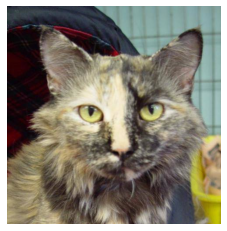

In [10]:
# OpenCV represents RGB images as multi-dimensional NumPy array but in the 
# reverse order. This means that images are actually represented in BGR order 
# rather than RGB. This can be corrected by converting BGR to RGB.
# cv2.cvtColor() method converts an image from one color space to another
plt.axis("off")
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.show()

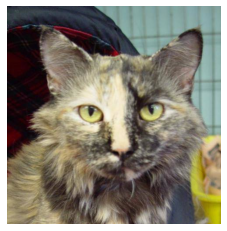

In [11]:
# or invert the channel order using slicing notation ::-1
plt.axis("off")
plt.imshow(img_color[:,:,::-1])
plt.show()

In [12]:
img_color.shape # (H, W, C)

(499, 489, 3)

In [13]:
# locations for training and test dataset
train_data_dir = '/content/training_set/training_set'
test_data_dir = '/content/test_set/test_set'

In [14]:
from torch.utils.data import DataLoader, Dataset

Generating target variables from file path information, since it contains the tags dog/cat

In [15]:
cats_try = glob(train_data_dir + '/cats/*.jpg')
cats_try[0].split('/') # splits the string into a list separated by '/'
cats_try[0].split('/')[-1] # return last list element: 'cat.3678.jpg'
cats_try[0].split('/')[-1].startswith('cat') # true if cat picture


True

Build a class that fetches data from the preceding folders, provides a label of 1 for dog and 0 for cat, normalize to 0-1, and permute channels (PyTorch expects channel first)

In [16]:
class CatsDogs(Dataset):
  def __init__(self, folder):
    # glob: Returns a list with file paths that matches 
    # the path specified (* == all)
    cats = glob(folder + '/cats/*.jpg')
    dogs = glob(folder + '/dogs/*.jpg')
    self.fpaths = cats + dogs  # adding two lists
    from random import shuffle, seed
    seed(10);
    # randomize file paths
    shuffle(self.fpaths)
    # list comprehension to generate ground truth
    self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths] # dog=1 & cat=0
  def __len__(self): 
    return len(self.fpaths)
  def __getitem__(self, ix):
    f = self.fpaths[ix] # return the file path
    target = self.targets[ix] # return ground truth
    im = (cv2.imread(f)[:,:,::-1])  # invert channel order to RGB
    im = cv2.resize(im, (224,224))  # resize images
    # Scale the images (/255), permute from (H, W, C) to (C,H,W), 
    # return image and label
    return torch.tensor(im/255).permute(2,0,1).to(device).float(), torch.tensor([target]).float().to(device)

Let's instatiate the class and give the location of the training set

In [17]:
data = CatsDogs(train_data_dir)
im, label = data[204] # this will call getitem method to return image and label
print('Size of data is ', len(data))

Size of data is  8005


In [18]:
'Dog' if label.tolist()[0]==1 else 'Cat'


'Dog'

data[204] is a  Dog


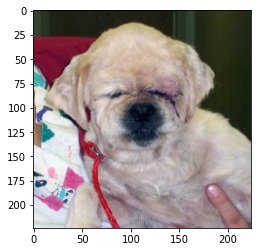

In [19]:
print('data[204] is a ','Dog' if label.tolist()[0]==1 else 'Cat')
plt.imshow(im.permute(1,2,0).cpu()) # from (C, H, W) back to (H, W, C), it is already RGB


data[201] is a  Cat


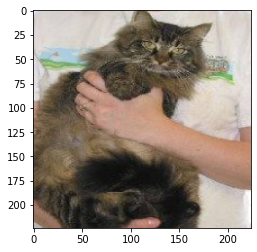

In [20]:
im, label = data[201] # this will call getitem method to return image and label
print('data[201] is a ','Dog' if label.tolist()[0]==1 else 'Cat')
plt.imshow(im.permute(1,2,0).cpu()) # back to (H, W, C), it is already RGB


Images have been resized correctly. 1 is dog, and 0 is cat

Now lets create one convolutional layer that includes convolution, activation function, batch normalization and max pooling. We will reutilize this layer

In [21]:
# ni, number of input channels
# no, number of output channels (feature maps)
# conv_layer: convolution + activeation + Batch norm + pooling
def conv_layer(ni,no,kernel_size,stride=1):
    return nn.Sequential( 
        nn.Conv2d(ni, no, kernel_size, stride),
        nn.ReLU(),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2)
        )

Now we create the CNN model

In [22]:
# create model
def get_model():
    model = nn.Sequential(
    conv_layer(3, 64, 3),
    conv_layer(64, 512, 3),
    conv_layer(512, 512, 3),
    conv_layer(512, 512, 3),
    conv_layer(512, 512, 3),
    conv_layer(512, 512, 3),
    nn.Flatten(),
    nn.Linear(512, 1),
    nn.Sigmoid(),
    ).to(device)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model, loss_fn, optimizer

In [23]:
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 222, 222]           1,792
              ReLU-2         [-1, 64, 222, 222]               0
       BatchNorm2d-3         [-1, 64, 222, 222]             128
         MaxPool2d-4         [-1, 64, 111, 111]               0
            Conv2d-5        [-1, 512, 109, 109]         295,424
              ReLU-6        [-1, 512, 109, 109]               0
       BatchNorm2d-7        [-1, 512, 109, 109]           1,024
         MaxPool2d-8          [-1, 512, 54, 54]               0
            Conv2d-9          [-1, 512, 52, 52]       2,359,808
             ReLU-10          [-1, 512, 52, 52]               0
      BatchNorm2d-11          [-1, 512, 52, 52]           1,024
        MaxPool2d-12          [-1, 512, 26, 26]               0
           Conv2d-13          [-1, 512, 24, 24]       2,359,808
             ReLU-14          [-1, 512,

function below will train the model on a batch of data

In [24]:
# Set up train batch
def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

Functions to calculate accuracy and validation

In [25]:
@torch.no_grad()
def accuracy(x, y, model):
    prediction = model(x)
    is_correct = (prediction > 0.5) == y # binary classification
    return is_correct.cpu().numpy().tolist()

In [26]:
@torch.no_grad()
def val_loss(x, y, model):
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

The function below creates an object CatsDogs, and DataLoader with a batch size of 32 for both training and validation. 

In [27]:
def get_data():     
    train = CatsDogs(train_data_dir)
    # ignore last batch (drop_last = True) as it might have size less than 32
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last = True)
    val = CatsDogs(test_data_dir)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
    return trn_dl, val_dl

Define model and fetch data loaders

In [28]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [29]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(20):
    
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for ix, batch in enumerate(iter(trn_dl)):
        #print(ix)
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
        #validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    #val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


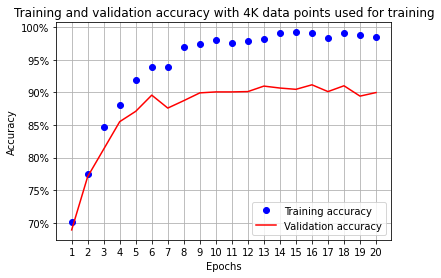

In [30]:
epochs = np.arange(20)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with 4K data points used for training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [31]:
# Misha folder path
misha1 = '/content/misha1.jpg'

In [32]:
img_color = cv2.imread(misha1, 1)

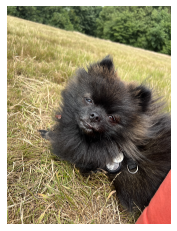

In [33]:
# OpenCV represents RGB images as multi-dimensional NumPy array but in the 
# reverse order. This means that images are actually represented in BGR order 
# rather than RGB. This can be corrected by converting BGR to RGB.
# cv2.cvtColor() method converts an image from one color space to another
plt.axis("off")
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.show()

In [34]:
im = (cv2.imread(misha1)[:,:,::-1])  # invert channel order to RGB
im = cv2.resize(im, (224,224))  # resize images
# Scale the images (/255), permute from (H, W, C) to (C,H,W), 
# return image and label
misha_normalized = torch.tensor(im/255).permute(2,0,1).to(device).float()

In [35]:
output = model(misha_normalized[None, ...])


In [36]:
output.tolist()[0][0]

0.7824000716209412

In [38]:
print('Efficacy of classifying Misha: ')
print('5 epochs\t 0.804 \t Classified as a Dog')
print('20 epochs\t 0.7824\t Classified as a Dog')
#print('50 epochs\t\t ')

Efficacy of classifying Misha: 
5 epochs	 0.804 	 Classified as a Dog
20 epochs	 0.7824	 Classified as a Dog


In [39]:
print('The A.I. detected this photo has a ','Dog' if output.tolist()[0][0]>0.5 else 'Cat')

The A.I. detected this photo has a  Dog


In [44]:
# Misha2 folder path
misha2 = '/content/misha2.jpg'

In [45]:
img_color = cv2.imread(misha2, 1)

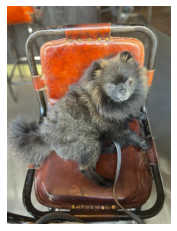

In [46]:
# OpenCV represents RGB images as multi-dimensional NumPy array but in the 
# reverse order. This means that images are actually represented in BGR order 
# rather than RGB. This can be corrected by converting BGR to RGB.
# cv2.cvtColor() method converts an image from one color space to another
plt.axis("off")
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.show()

In [47]:
im = (cv2.imread(misha2)[:,:,::-1])  # invert channel order to RGB
im = cv2.resize(im, (224,224))  # resize images
# Scale the images (/255), permute from (H, W, C) to (C,H,W), 
# return image and label
misha_normalized = torch.tensor(im/255).permute(2,0,1).to(device).float()

In [48]:
output = model(misha_normalized[None, ...])


In [49]:
output.tolist()[0][0]

0.7270816564559937

In [52]:
print('Efficacy of classifying Misha: ')
print('5 epochs\t 0.0931 \t Classified as a Cat')
print('20 epochs\t 0.7270 \t Classified as a Dog')
#print('50 epochs\t ')

Efficacy of classifying Misha: 
5 epochs	 0.0931 	 Classified as a Cat
20 epochs	 0.7270 	 Classified as a Dog


In [53]:
print('The A.I. detected this photo has a ','Dog' if output.tolist()[0][0]>0.5 else 'Cat')

The A.I. detected this photo has a  Dog


As you can see the A.I. needed a little more than 5 epochs of training to be able to correctly identify Misha. Success!!

Acknolegdments: The author would like to thank Misha for gratiously let him use his image for testing this A.I. model. 
